### Cost Benefit Questions

1. How would you rephrase the business problem if your model was optimizing toward _precision_? i.e., How might the model behave differently, and what effect would it have?
2. How would you rephrase the business problem if your model was optimizing toward _recall_?
3. What would the most ideal model look like in this case?


In [12]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression

titanic = pd.read_csv('titanic.csv')
titanic.set_index('PassengerId', inplace=True)
titanic = titanic.join(pd.get_dummies(titanic.Pclass))
titanic['is_male'] = titanic.Sex.apply(lambda x: 1 if x == 'male' else 0)

titanic.groupby('Survived').Age.hist()

FileNotFoundError: File b'titanic.csv' does not exist

In [ ]:
titanic['Age'] = titanic.groupby(["Sex", 'Pclass']).Age.transform(lambda x: x.fillna(x.mean()))
titanic['had_parents'] = titanic.Parch.apply(lambda x: 1 if x > 0 else 0)
titanic['had_siblings'] = titanic.SibSp.apply(lambda x: 1 if x > 0 else 0)

In [ ]:
from sklearn import grid_search, cross_validation

feature_set = titanic[['is_male', 1, 2, 'Fare', 'Age', 'had_parents', 'had_siblings']]
cv=cross_validation.KFold(n=len(titanic), n_folds=10)
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    cv=cv,
    scoring='roc_auc'
)


gs.fit(feature_set, titanic.Survived)
print(gs.best_estimator_)

In [ ]:
titanic['prob'] = gs.predict_proba(feature_set).T[1]
titanic['predict'] = gs.predict(feature_set)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

mod = gs.best_estimator_

actuals = mod.predict(feature_set) 
probas = mod.predict_proba(feature_set)
plt.plot(roc_curve(titanic[['Survived']], probas[:,1])[0], roc_curve(titanic[['Survived']], probas[:,1])[1])

In [ ]:
for c in [10**-i for i in range(-5, 5)]:
    for class_weight in [None, 'balanced']:
        gs_ind = grid_search.GridSearchCV(
        estimator=LogisticRegression(),
        cv=cv,
        param_grid={'C': [c], 'class_weight': [class_weight]},
        scoring='roc_auc')
        
        gs_ind.fit(feature_set, titanic.Survived)
        actuals = gs_ind.predict(feature_set) 
        probas = gs_ind.predict_proba(feature_set)
        plt.plot(roc_curve(titanic[['Survived']], probas[:,1])[0], roc_curve(titanic[['Survived']], probas[:,1])[1])

In [ ]:
roc_auc_score(titanic['Survived'], mod.predict_proba(feature_set)[:,1])

In [ ]:
import numpy as np
score = []
for train, test in cv:
    score.append(roc_auc_score(titanic.Survived.iloc[test], mod.predict_proba(feature_set.iloc[test])[:,1]))
print(np.mean(score))

### Visualizing models over variables

In [13]:
%matplotlib inline

In [14]:
import pandas as pd
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('flight_delays.csv')
df = df.loc[df.DEP_DEL15.notnull()].copy()

In [15]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855.0,0.0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856.0,0.0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226.0,0.0,NaN
3,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,1220,1214.0,0.0,NaN
4,1,4,2015-01-01,AA,19805,AA,11298,1129803,30194,12173,1217302,32134,1305,1754.0,1.0,NaN


In [16]:
df = df[df.DEP_DEL15.notnull()]
df = df.join(pd.get_dummies(df['CARRIER'], prefix='carrier'))
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
model = lm.LogisticRegression()
features = [i for i in df.columns if 'dow_' in i]

In [17]:
df.shape

(458311, 37)

In [18]:
features += ['CRS_DEP_TIME']
model.fit(df[features[1:]], df['DEP_DEL15'])

df['probability'] = model.predict_proba(df[features[1:]]).T[1]

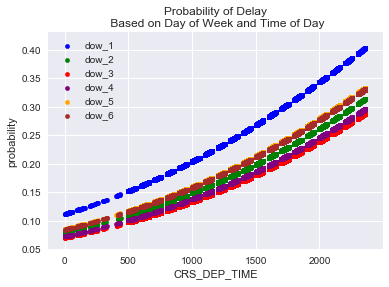

In [19]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for e, c in enumerate(colors):
    df[df[features[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', color = c, ax=ax, label=features[e])

ax.set(title='Probability of Delay\n Based on Day of Week and Time of Day')


### Other Answers: visualizing Airline or the inverse

In [28]:
features2 = [i for i in df.columns if 'carrier_' in i]
features2 += ['CRS_DEP_TIME']

model.fit(df[features2[1:]], df['DEP_DEL15'])
df['probability'] = model.predict_proba(df[features2[1:]]).T[1]

features2

['carrier_AA',
 'carrier_AS',
 'carrier_B6',
 'carrier_DL',
 'carrier_EV',
 'carrier_F9',
 'carrier_HA',
 'carrier_MQ',
 'carrier_NK',
 'carrier_OO',
 'carrier_UA',
 'carrier_US',
 'carrier_VX',
 'carrier_WN',
 'CRS_DEP_TIME']

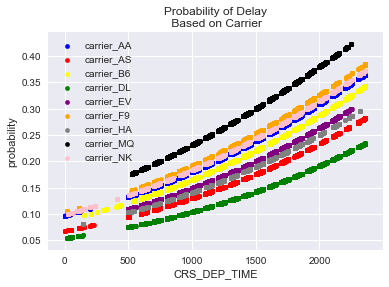

In [31]:
ax = plt.subplot(111)

c=['blue','red','yellow','green','purple','orange','grey','black','pink']

for e, c in enumerate(c):
    df[df[features2[e]] == 1].plot(x='CRS_DEP_TIME'
                                   , y='probability'
                                   , kind='scatter'
                                   , ax=ax
                                   , label=features2[e]
                                   , color = c)

ax.set(title='Probability of Delay\n Based on Carrier')

#loops until it runs out of colours

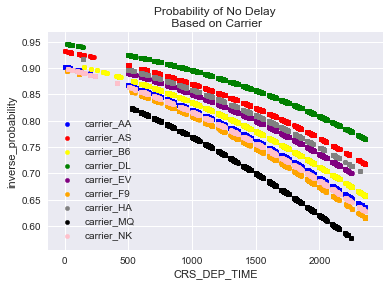

In [32]:
df['inverse_probability'] = model.predict_proba(df[features2[1:]]).T[0]

c=['blue','red','yellow','green','purple','orange','grey','black','pink']

ax = plt.subplot(111)

for e, c in enumerate(c):
    df[df[features2[e]] == 1].plot(x='CRS_DEP_TIME'
                                   , y='inverse_probability'
                                   , kind='scatter'
                                   , ax=ax
                                   , color=c
                                   , label=features2[e])

ax.set(title='Probability of No Delay\n Based on Carrier')

### Visualizing Performance Against Baseline

#### Visualizing AUC and comparing Models

In [40]:
from sklearn import dummy, metrics

In [35]:
model0 = dummy.DummyClassifier()
model0.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_0'] = model0.predict_proba(df[features[1:]]).T[1]

model1 = lm.LogisticRegression()
model.fit(df[features[1:]], df['DEP_DEL15'])
df['probability_1'] = model.predict_proba(df[features[1:]]).T[1]


In [36]:
df.shape

(458311, 41)

[(0, 1),
 (0, 1),

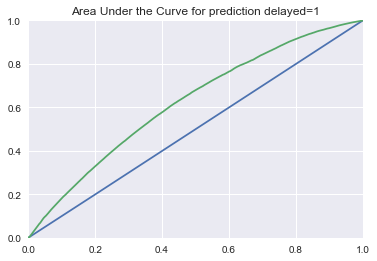

In [37]:
ax = plt.subplot(111)
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_0)
ax.plot(vals[0], vals[1])
vals = metrics.roc_curve(df.DEP_DEL15, df.probability_1)
ax.plot(vals[0], vals[1])

ax.set(title='Area Under the Curve for prediction delayed=1', ylabel='', xlabel='', xlim=(0, 1), ylim=(0, 1))

In [41]:
metrics.roc_curve(df.DEP_DEL15,df.probability_0)

(array([ 0.        ,  0.19845481,  1.        ]),
 array([ 0.        ,  0.19783904,  1.        ]),
 array([2, 1, 0]))

#### Visualizing Precision / Recall

In [42]:
metrics.precision_recall_curve(df.DEP_DEL15,df['probability_0'])

(array([ 0.19850713,  0.19801316,  1.        ]),
 array([ 1.        ,  0.19783904,  0.        ]),
 array([0, 1]))